
<div style="text-align:left;font-size: 0.8em; color: #444;line-height: 0.9;font-family: Palatino;">  
<strong>NOTE:</strong>  This notebook, provided under the terms of the MIT licensing, demonstrates the usage of CARTMAN functions. For the most up-to-date version of this document and the CARTMAN tool, please visit <a href="https://github.com/psaisan/CARTMAN"> github.com/psaisan/CARTMAN </a>.
<hr>
</div>
<div style="background-color: #FFF; border: 1px solid #333333; padding: 10px; font-size: 0.88em; font-family:
    font-family: Palatino, Book Antiqua;text-align:left">
<h1>
CARTMAN Analysis of Motif Co-occurences in Active Peaks of Healthy vs. Diseased Kupffer Cells</h1>    
</div>

<br>     
As outlined in  <a href="https://pubmed.ncbi.nlm.nih.gov/32362324/"> Seidman et al</a>, using transcriptomic data <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128338"> (GSE128338)</a> associated with Fig 5B, we defined putative distal regulatory elements by annotating open regions of chromatin determined by ATAC seq with local (1000bp window) Histone H3K27 acetylation (H3K27ac) determined by ChIP seq in Kupffer cells isolated from healthy mice or from mice fed a diet that induces metabolic dysfunction associated hepatosteatosis (MASH). We observed 3717 regions that exhibited a more than 2-fold increase in H3K27ac and more than 2678 regions exhibiting more than a 2-fold decrease in acetylation (FDR <0.05) in Kupffer cells isolated from mice fed the MASH-inducing diet.  


<img src="../Images/peaks_scatter.PNG" style="border: 0; display: block; margin: -1 auto; max-width: 50%; height: auto;" alt="Description of Image">


These changes in H3K27ac were associated with corresponding up or down regulation of nearby genes, respectively.  Motif enrichment analysis of DNA sequences of ATAC peaks associated with gain or loss of acetylation resulted in identification in each case of more than 20 motifs that were significantly enriched in comparison to GC matched background, nominating candidate transcription factors as drivers of the changes in H3K27ac. Among these, motifs for Kupffer cell lineage determining factors PU.1/SpiB, IRFs, LXR and TEF were identified as the most enriched motifs in ATAC peaks exhibiting reduced H3K27ac, whereas motifs for PU.1, ATF3, AP-1 and MITF were the most enriched motifs in ATAC peaks exhibiting increased H3K27ac. These motifs are, therefore, among the limited target motif set used in co-occurance analysis below (motif_list_file).

To investigate the possibility that these overlapping motifs are used in different **combinations** to drive the patterns of observed acetylation in healthy vs MASH Kupffer cells, we analyzed, using CARTMAN below, the frequencies of all possible combinations of target set motifs in each of the peak sets. This analysis helped reveal that the combination of an ATF3 motif with any of the other factors was significantly over represented in the peaks gaining H3K27ac Kupffer cells isolated from mice fed the MASH-inducing diet. In contrast, combinations of  motifs for Kupffer cell lineage determining factors but lacking the ATF3 motif were significantly enriched in peaks that exhibited loss of H3K27ac in the context of the MASH diet.  Of interest, the motifs associated with motifs recognized by LXR, (LXRE and LXR half site) changed from motifs being recognized by other Kupffer cell lineage determining factors in healthy Kupffer cells to combinations containing the ATF3 motif in Kupffer cells isolated from mice fed the MASH diet. These findings are consistent with marked up regulation of ATF3 in Kupffer cells fed the MASH diet and its binding to genomic regions exhibiting increased H3K27ac in conjunction with co-binding of LXRs. 

<img src="../results/differential_CARTMAN.PNG" style="border: 0; display: block; margin: -1 auto; max-width: 50%; height: auto;" alt="Description of Image">

<br>

</div>
 


In [10]:
import sys
import os

# Add the src directory to the Python path
current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))
sys.path.append(os.path.dirname(current_dir)+'/src/')
os.environ["PATH"] += "/bioinformatics/homer/bin:"


# Imports from motif_utils.py
from src.motif_utils import (
    read_motif_headers,
    is_denovo_motif_file,
    read_motif_headers_jaspar,
    read_motif_headers_homer
)

# Imports from HOMER_utils.py
from src.HOMER_utils import get_motif_count

# Imports from combination_utils.py
from src.combination_utils import (
    all_possible_combinations33,
    transform_combinations_to_matrix,
    calculate_all_motif_co_occurrences
)

# Imports from peak_motif_analysis.py
from src.peak_motif_sets import peak_motif_sets


DENOVO HOMER
Motif_Count_File= /gpfs/data01/glasslab/home/psaisan/code/data/motifCount_counts_KCN_H3K_FC2_1000_w200_KCH_VS_KCN_w400_L70_REDUCED.txt Force= False
** Loading ** /gpfs/data01/glasslab/home/psaisan/code/data/motifCount_counts_KCN_H3K_FC2_1000_w200_KCH_VS_KCN_w400_L70_REDUCED.txt


/gpfs/data01/glasslab/home/psaisan/code/src/peak_motif_sets.py:128: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig_upset.savefig(upset_image_path, bbox_inches="tight")


Save results in : /gpfs/data01/glasslab/home/psaisan/code/results/Peak1_table.txt
DENOVO HOMER
Motif_Count_File= /gpfs/data01/glasslab/home/psaisan/code/data/motifCount_counts_KCH_H3K_FC2_1000_w200_KCH_VS_KCN_w400_L70_REDUCED.txt Force= False
** Loading ** /gpfs/data01/glasslab/home/psaisan/code/data/motifCount_counts_KCH_H3K_FC2_1000_w200_KCH_VS_KCN_w400_L70_REDUCED.txt


/gpfs/data01/glasslab/home/psaisan/code/src/peak_motif_sets.py:128: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig_upset.savefig(upset_image_path, bbox_inches="tight")


Save results in : /gpfs/data01/glasslab/home/psaisan/code/results/Peak2_table.txt


/gpfs/data01/glasslab/home/psaisan/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/gpfs/data01/glasslab/home/psaisan/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


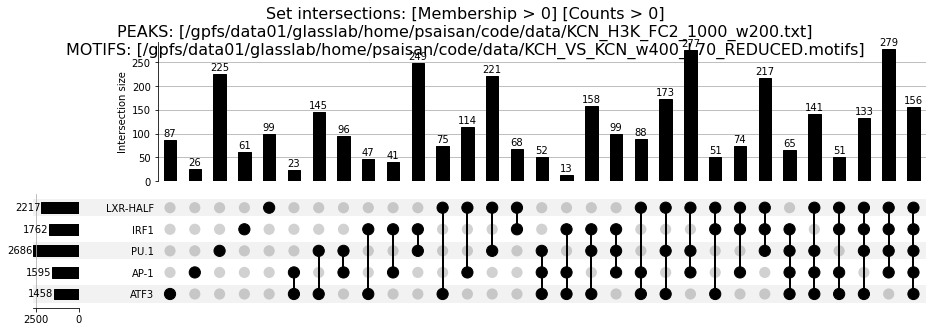

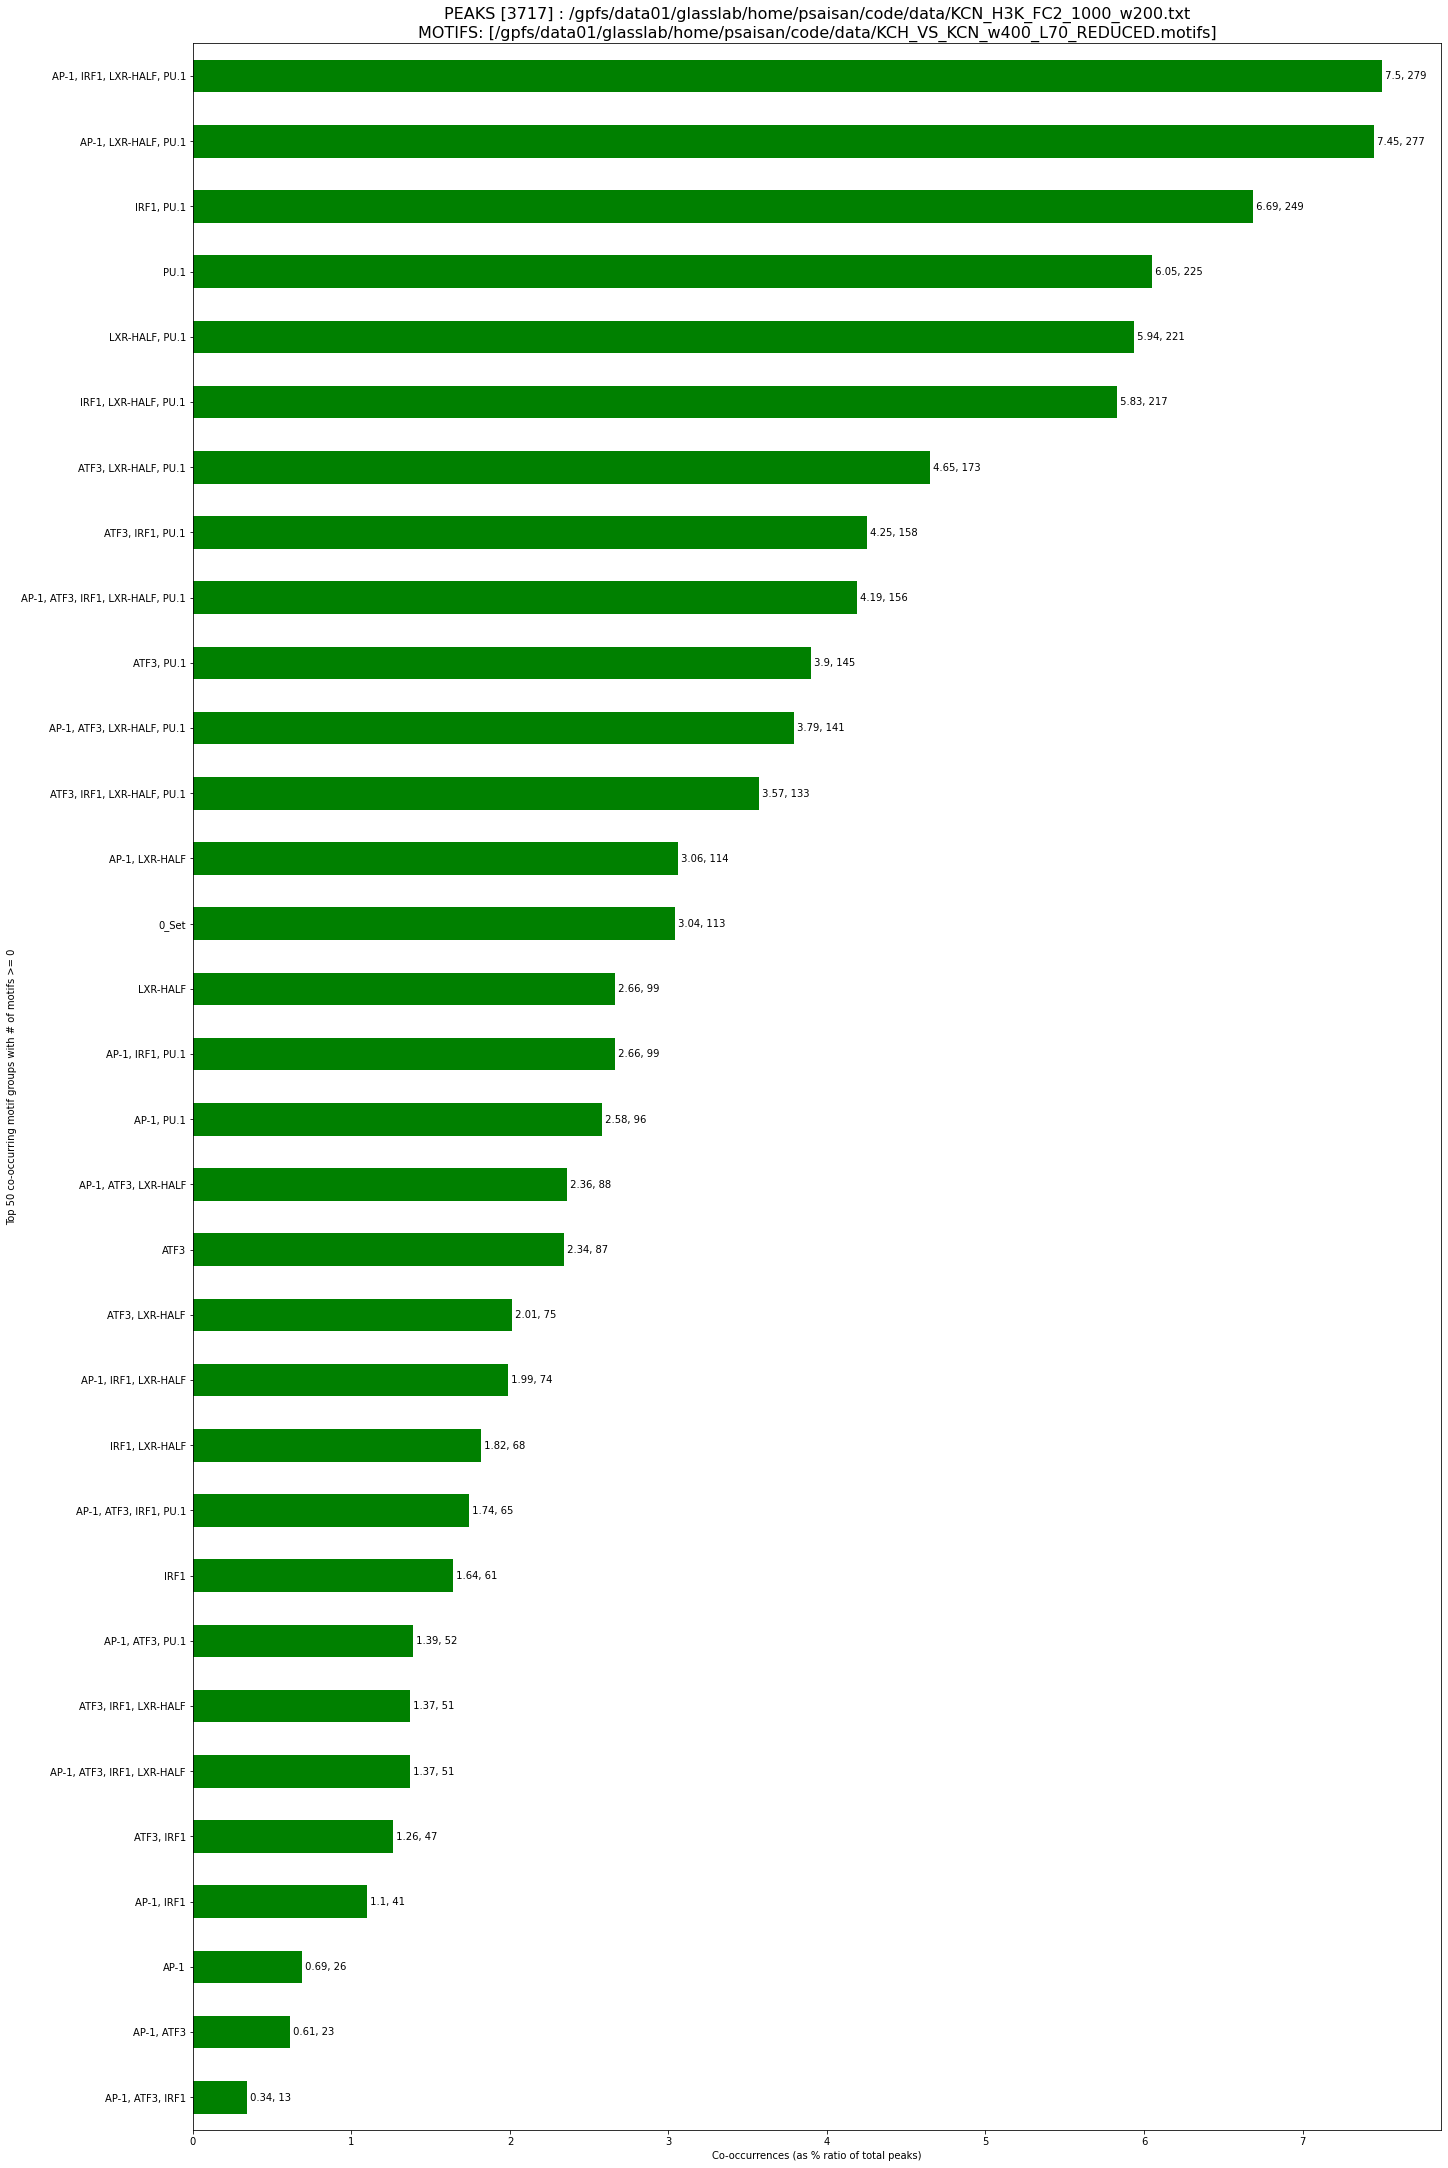

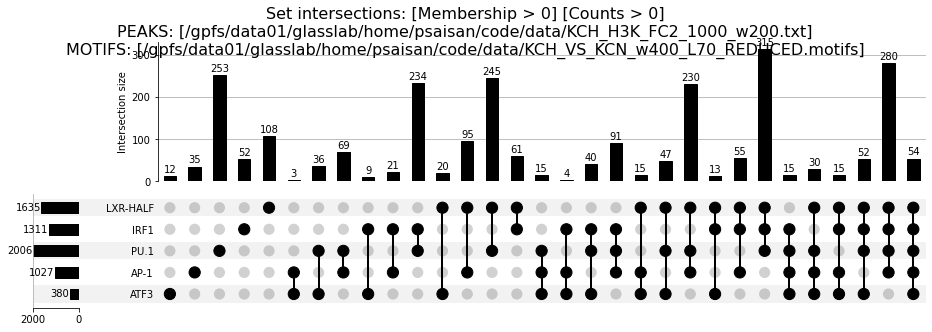

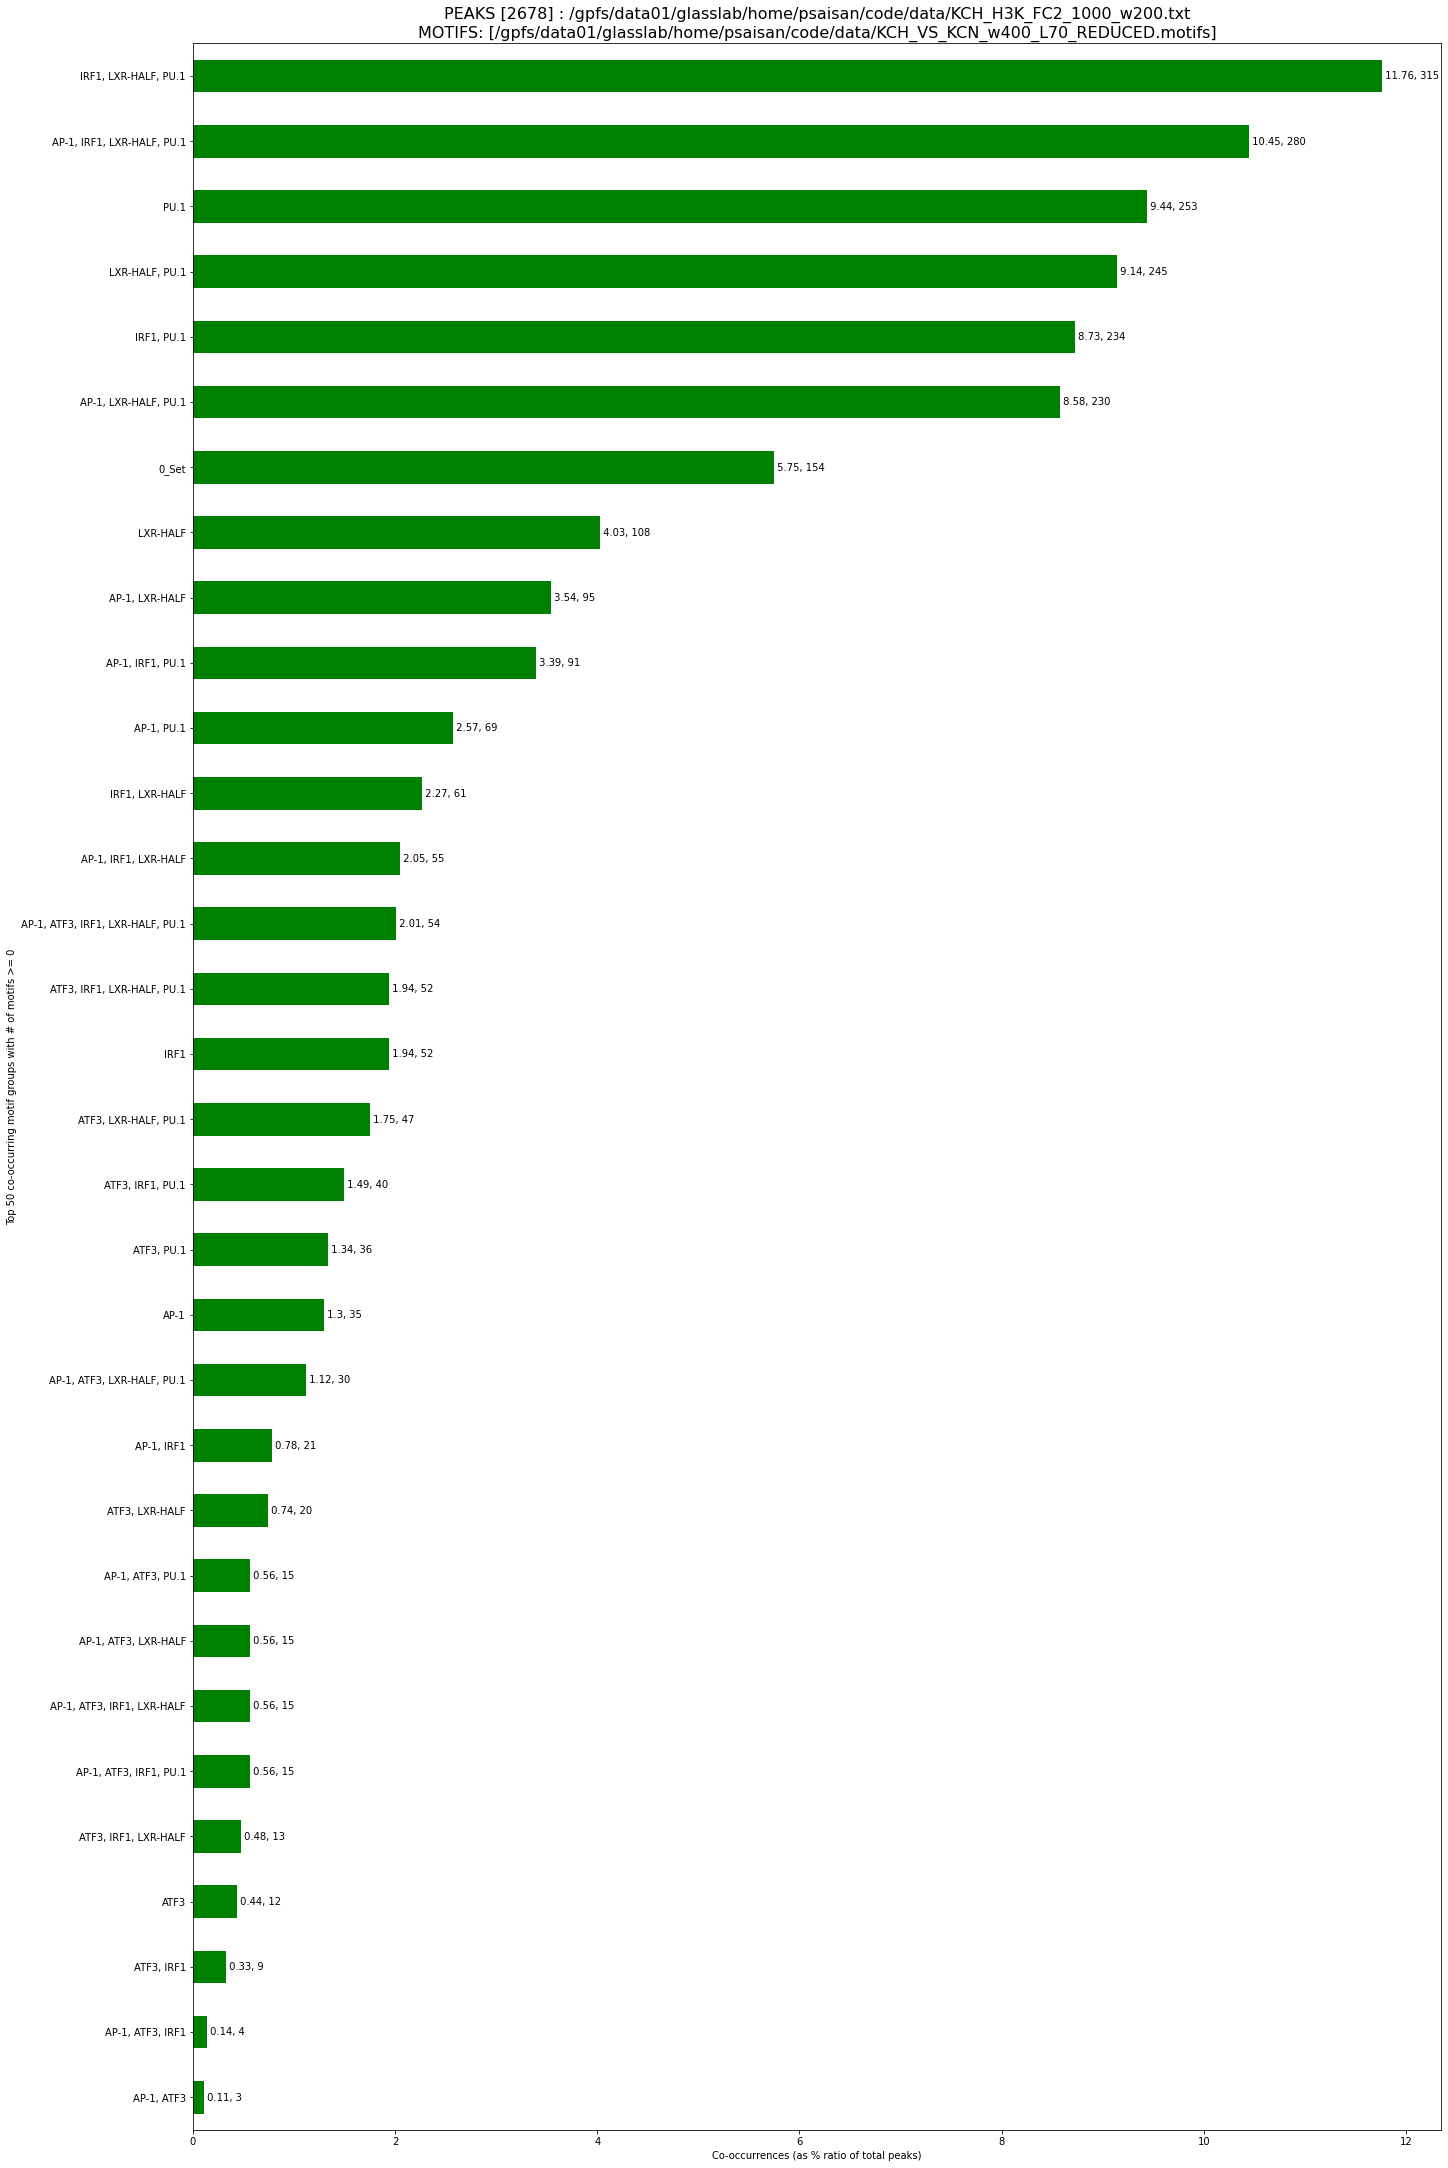

In [16]:
from upsetplot import plot
import matplotlib.pyplot as plt
import os
import pandas as pd

# -------------------------
# Configuration and Setup
# -------------------------

# Base directory path for data and outputs
cwd= os.getcwd()
base_dir_in=cwd+'/data/'
base_dir_out=cwd+'/results/'


# Genome reference
GENOME = 'mm10'

# Motif list file path
motif_list_file = os.path.join(base_dir_in, 'KCH_VS_KCN_w400_L70_REDUCED.motifs')

# Peak files
peak_file1 = os.path.join(base_dir_in, 'KCN_H3K_FC2_1000_w200.txt')
peak_file2 = os.path.join(base_dir_in, 'KCH_H3K_FC2_1000_w200.txt')

# Output directories
output_directory1 = os.path.join(base_dir_out, 'Example_Peak1/')
output_directory2 = os.path.join(base_dir_out, 'Example_Peak2/')

# CSV output paths for Peak 1 and 2
csv_out_file1 = os.path.join(base_dir_out, 'Peak1_table.txt')
csv_out_file2 = os.path.join(base_dir_out, 'Peak2_table.txt')

# Image output base paths
fig_output_path1 = os.path.join(base_dir_out, 'Peak1.png')  # Function appends _upset.png and _bar.png
fig_output_path2 = os.path.join(base_dir_out, 'Peak2.png')  # Function appends _upset.png and _bar.png


# Parameters with default values
motif_recount = False
seperate_duplicates = False
min_motif_set_count = 0
min_subset_count = 0

# -------------------------
# Processing Peak File 1
# -------------------------

# Call the peak_motif_sets function with appropriate parameters
dp1, bdf1 = peak_motif_sets(
    peak_file=peak_file1,
    genome=GENOME,
    motif_list_file=motif_list_file,
    Motif_recount=motif_recount,
    seperate_duplicates=seperate_duplicates,
    min_motif_set_count=min_motif_set_count,
    min_subset_count=min_subset_count,
    output_file=fig_output_path1
)

 

# Save the binary table to a CSV file for Peak 1
print('Save results in :',csv_out_file1)
bdf1.to_csv(csv_out_file1, sep='\t')

# -------------------------
# Processing Peak File 2
# -------------------------

# Call the peak_motif_sets function with appropriate parameters
dp2, bdf2 = peak_motif_sets(
    peak_file=peak_file2,
    genome=GENOME,
    motif_list_file=motif_list_file,
    Motif_recount=motif_recount,
    seperate_duplicates=seperate_duplicates,
    min_motif_set_count=min_motif_set_count,
    min_subset_count=min_subset_count,
    output_file=fig_output_path2
)


# Save the binary table to a CSV file for Peak 2
print('Save results in :',csv_out_file2)
bdf2.to_csv(csv_out_file2, sep='\t')


In [32]:
# Inspect results: motif combinations table
print('===')
print('Motif co-occurance counts (normalized %) for '+peak_file1)
print('===')
print(dp1)

print('===')
print('Outuput File : ',csv_out_file1)
print('===')
display(pd.read_csv(csv_out_file1,delimiter='\t'))


===
Motif co-occurance counts (normalized %) for /home/psaisan/code//data/KCN_H3K_FC2_1000_w200.txt
===
IRF1(IRF), LXR-HALF, MITF(bHLH)                                       0.69
ATF3, LXR-HALF, MITF(bHLH), TEF                                       0.69
AP-1, IRF1(IRF), MITF(bHLH), PB0058.1_Sfpi1_1                         0.69
LXR-HALF                                                              0.72
ATF3, LXR-HALF, PB0058.1_Sfpi1_1                                      0.72
LXR-HALF, MITF(bHLH), TEF                                             0.75
MITF(bHLH)                                                            0.78
AP-1, IRF1(IRF), LXR-HALF, PB0058.1_Sfpi1_1, TEF                      0.80
AP-1, ATF3, IRF1(IRF), MITF(bHLH), PB0058.1_Sfpi1_1, TEF              0.80
LXR-HALF, PB0058.1_Sfpi1_1, TEF                                       0.80
AP-1, IRF1(IRF), LXR-HALF, MITF(bHLH), TEF                            0.80
ATF3, MITF(bHLH)                                                      0

,PeakID,ATF3,AP-1,MITF(bHLH),PB0058.1_Sfpi1_1,IRF1(IRF),LXR-HALF,TEF,"LXRE(NR),DR4"
0,Merged-chrUn_GL456389-10653-2,0,1,1,0,1,0,0,0
1,Merged-chr9-35305408-2,0,1,0,0,1,0,1,0
2,Merged-chr14-19417842-2,0,1,0,1,1,0,1,0
3,Merged-chr2-134644199-2,0,0,1,0,0,1,1,0
4,Merged-chr9-3002152-2,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
3712,Merged-chr8-10848293-1,0,1,0,1,1,0,0,0
3713,Merged-chr9-69454384-1,1,0,0,1,0,1,0,0
3714,Merged-chr10-120980286-1,0,1,0,1,0,1,1,0
3715,Merged-chr8-126588056-1,0,1,1,0,0,1,0,0
